## Installing requirements

In [1]:
# Only when running in Colab
!pip install git+https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git to /tmp/pip-req-build-8ilijkj8
  Running command git clone -q https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git /tmp/pip-req-build-8ilijkj8
  Created wheel for src: filename=src-0.1.0-py3-none-any.whl size=2919 sha256=fc81e90da7a6caf1b4f0a71c4fa9c9c01027133dc121b182803777b56b605519
  Stored in directory: /tmp/pip-ephem-wheel-cache-kjdax9gt/wheels/05/26/e4/331bb032dbc294e55b1e141b7a6595a14c0e57d6c05184dc51
Successfully built src
You should consider upgrading via the '/home/maria/Documents/nomagic/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
!pip install pytorch-lightning
!pip install pytorch-toolbelt
!pip install ternausnet
!pip install pretrained-backbones-unet
!pip install imagecodecs
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [ ]:
from __future__ import annotations

import pytorch_lightning as pl
import wandb
from google.colab import drive
from matplotlib import pyplot as plt
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader

from src.data import RandomPatchesDataset
from src.models import UNetLit

## Mounting Google Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Logging in to Wandb

In [ ]:
wandb.login()

## Loading data

In [ ]:
batch_size = 12
PATH = '/content/drive/MyDrive/Cell_segmentation'
train_dataset = RandomPatchesDataset(
    f'{PATH}/train/img',
    f'{PATH}/train/mask',
)
train_data_loader = DataLoader(train_dataset, batch_size = batch_size)

val_dataset = RandomPatchesDataset(
    f'{PATH}/val/img',
    f'{PATH}/val/mask',
)
val_data_loader = DataLoader(val_dataset, batch_size = batch_size)

test_dataset = RandomPatchesDataset(
    f'{PATH}/test/img',
    f'{PATH}/test/mask',
)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size)

Succesfully loaded 38 images
Succesfully loaded 4 images
Succesfully loaded 37 images


## Training

In [ ]:
config = {
    "lr": 0.001,
    "eps": 1.0e-08,
    "step_size": 4,
    "gamma": 0.1
}
num_epochs = 100
checkpoints_dir_path = './models'
project = 'cell-nuclei-segmentation'
gpus = 0

model = UNetLit(config)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    dirpath=checkpoints_dir_path,
    filename='model-{epoch:02d}-{val_acc:.2f}',
    save_top_k=1,
    mode='max',
)
wandb_logger = WandbLogger(save_dir="logs/", project=project)
trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=num_epochs,
    callbacks=[checkpoint_callback],
    )

trainer.fit(model, train_data_loader, val_data_loader)
wandb.finish() 

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type            | Params
--------------------------------------------
0 | model   | Unet            | 5.8 M 
1 | loss_fn | BinaryFocalLoss | 0     
--------------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.336    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_acc,▁▇▇▆▆▇█▇▆▆▇▇▇▆▇▇▇▆▆▇▇▇▆▅▆▇█▆▇▆▇▇▇▆▇▆▇▇▅▇
train_loss,▁▁▁▄▃▁▁█▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▁████▇██▇███▇▇███▇▇███▇█████▇▇██▇██▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_acc,0.94064
train_loss,0.03437
trainer/global_step,499
val_acc,0.93709


## Evaluation & analysing the predictions

In [ ]:
MODEL_CHECKPOINT_PATH = "/home/maria/Downloads/model-epoch=81-val_acc=0.96.ckpt"
model = UNetLit.load_from_checkpoint(MODEL_CHECKPOINT_PATH)
for img, mask in test_data_loader:
    real_mask = mask[0].cuda()
    real_img = img[0].cuda()
    output = model(real_img.float().unsqueeze(dim=1))
    break

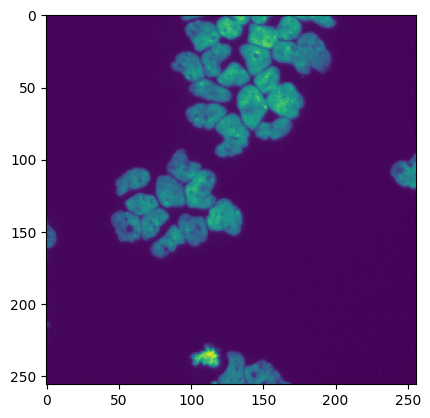

In [ ]:
plt.imshow(real_img.cpu().squeeze(), cmap='gray')

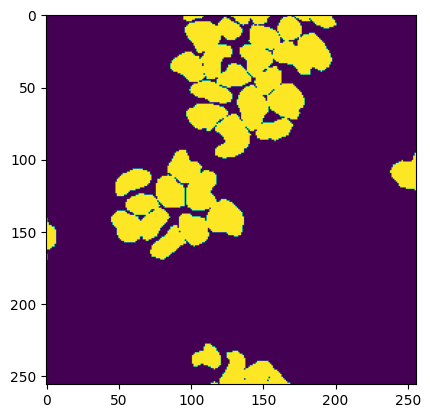

In [ ]:
plt.imshow(real_mask.cpu().squeeze(), cmap='gray')

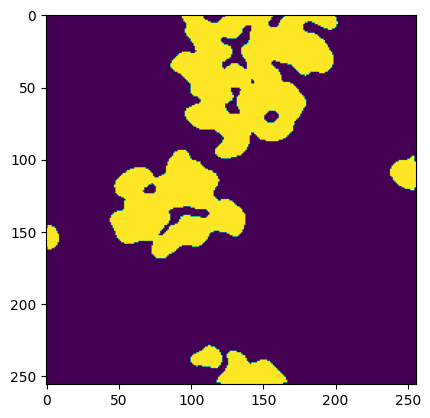

In [ ]:
plt.imshow((output.cpu() > 0.5).float().squeeze().detach(), cmap='gray')